In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
import sklearn.metrics as metrics
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras. preprocessing.image import *
from keras import optimizers
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from sklearn.metrics import mean_squared_error
import matplotlib.image as mpmig
import h5py
import cv2

## Check if GPU is avaliale

In [17]:
#K.tensorflow_backend._get_available_gpus()
tf.test.is_gpu_available()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
CUDA_VISIBLE_DEVICES="0"

Num GPUs Available:  1


In [18]:
covid_dir = os.path.join('train/Covid')
normal_dir = os.path.join('train/Normal')
pneu_dir = os.path.join('train/Viral Pneumonia')

## Show some images in the training set

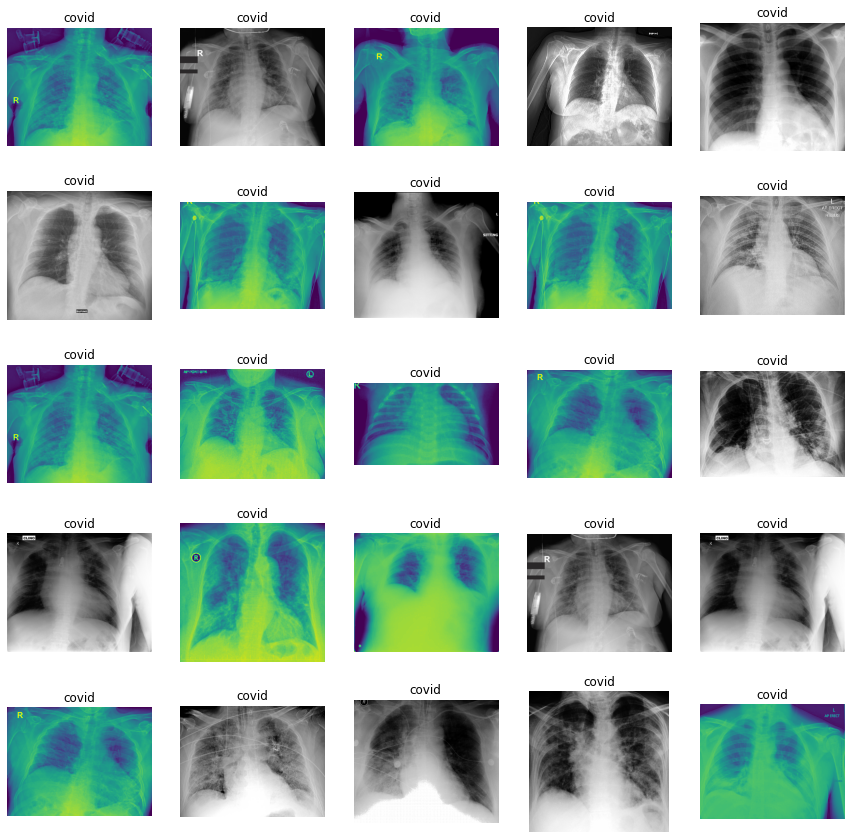

In [19]:
covid = os.listdir(covid_dir)
normal = os.listdir(normal_dir)
pneu = os.listdir(pneu_dir)

plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.title('covid')
    pic_index = np.random.randint(0, len(covid))
    img_path = os.path.join(covid_dir, covid[pic_index])
    img = mpmig.imread(img_path)
    plt.axis('Off')
    plt.imshow(img)

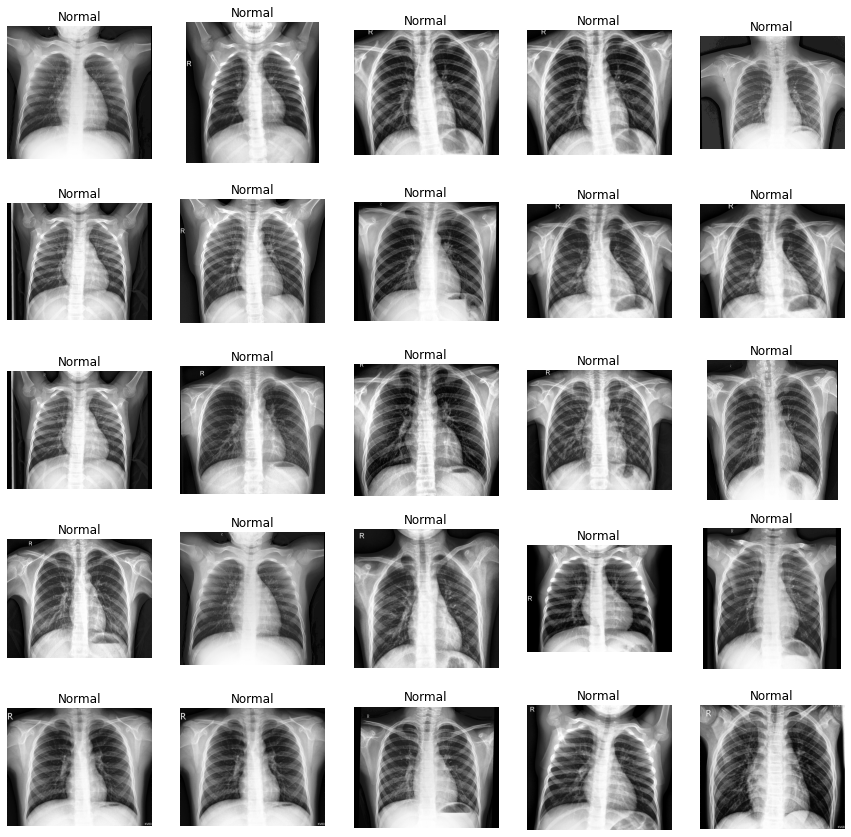

In [20]:
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.title('Normal')
    pic_index = np.random.randint(0, len(normal))
    img_path = os.path.join(normal_dir, normal[pic_index])
    img = mpmig.imread(img_path)
    plt.axis('Off')
    plt.imshow(img)

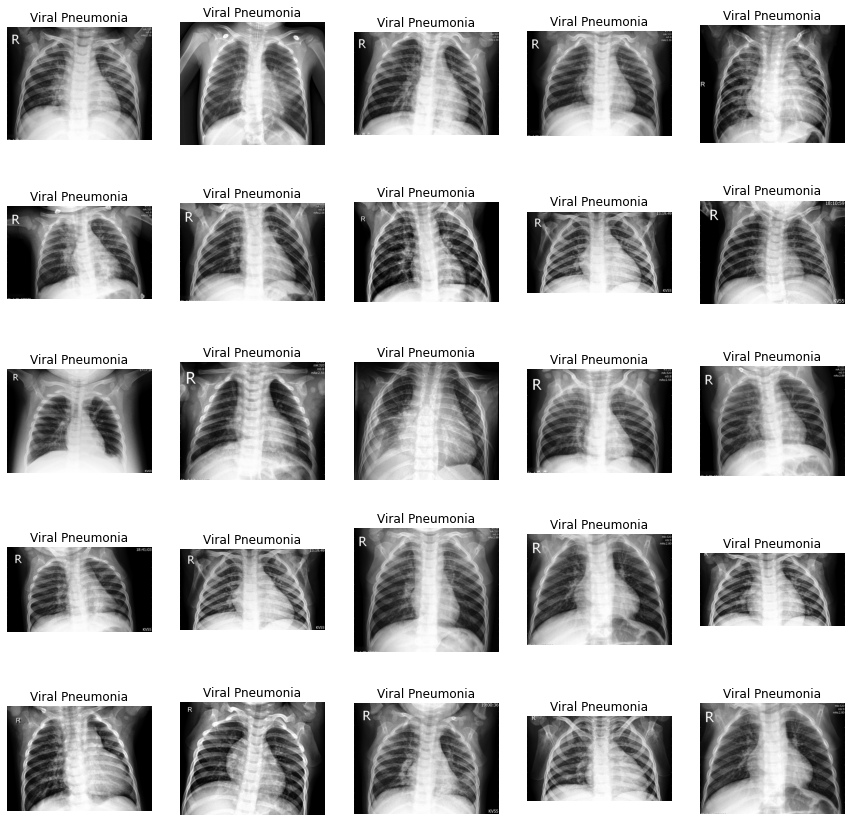

In [21]:
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.title('Viral Pneumonia')
    pic_index = np.random.randint(0, len(pneu))
    img_path = os.path.join(pneu_dir, pneu[pic_index])
    img = mpmig.imread(img_path)
    plt.axis('Off')
    plt.imshow(img)

## Preprocess the training data: scale, rotate, flip and shear. Avoid overfitting
## Read images from files

In [23]:
train_gen = ImageDataGenerator(rescale = 1/255,
                                  rotation_range = 20,
                                  #width_shift_range = 0.2,
                                  #height_shift_range = 0.2,
                                  horizontal_flip = True,
                                  shear_range = 0.2,
                                  fill_mode = 'nearest'
                                  #vertical_flip=True
                              )

test_gen = ImageDataGenerator(rescale = 1/255)

train_generator = train_gen.flow_from_directory(
        'train', 
        target_size = (150, 150), 
        batch_size = 32,
        class_mode = 'categorical')

test_generator = test_gen.flow_from_directory(directory = 'test', 
                                              target_size = (150,150), 
                                              shuffle = False, batch_size = 32, class_mode = 'categorical')

print(train_generator.class_indices)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


# Build CNN

In [30]:
model = Sequential()
model.add(Conv2D(128, kernel_size=5, activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(pool_size=(5,5), strides=(2,2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer = optimizers.Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 146, 146, 128)     9728      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 71, 71, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 73984)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               9470080   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

## Define the criteria of early stopping

In [31]:
early_stopping = EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

## Train the base model

In [32]:
history = model.fit(train_generator, 
                    epochs=20,
                    batch_size=32, callbacks = [early_stopping])

Epoch 1/20
8/8 [==============================] - 7s 861ms/step - loss: 1.9931 - acc: 0.3506
Epoch 2/20
8/8 [==============================] - 7s 855ms/step - loss: 0.9714 - acc: 0.5378
Epoch 3/20
8/8 [==============================] - 7s 858ms/step - loss: 0.6628 - acc: 0.7092
Epoch 4/20
8/8 [==============================] - 7s 832ms/step - loss: 0.4033 - acc: 0.8327
Epoch 5/20
8/8 [==============================] - 7s 840ms/step - loss: 0.3752 - acc: 0.8327
Epoch 6/20
8/8 [==============================] - 7s 909ms/step - loss: 0.3486 - acc: 0.8606
Epoch 7/20
8/8 [==============================] - 7s 870ms/step - loss: 0.2818 - acc: 0.8845
Epoch 8/20
8/8 [==============================] - 6s 781ms/step - loss: 0.3233 - acc: 0.8685
Epoch 9/20
8/8 [==============================] - 7s 859ms/step - loss: 0.2702 - acc: 0.9004
Epoch 10/20
8/8 [==============================] - 7s 852ms/step - loss: 0.2786 - acc: 0.8964
Epoch 11/20
8/8 [==============================] - 7s 819ms/step - lo

## Plot the accuracy trends during training

Text(0, 0.5, 'Accuracy')

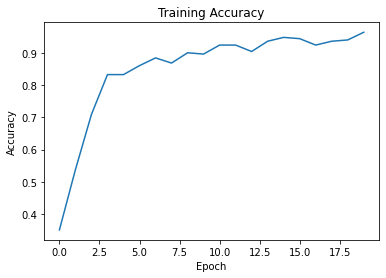

In [33]:
acc = history.history['acc']

plt.title('Training Accuracy')
sns.lineplot(data = acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

## Summary of the model performance

In [34]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 
report = metrics.classification_report(true, predicted_classes, target_names=class_labels)
print(report)

                 precision    recall  f1-score   support

          Covid       1.00      0.92      0.96        26
         Normal       0.80      1.00      0.89        20
Viral Pneumonia       1.00      0.85      0.92        20

       accuracy                           0.92        66
      macro avg       0.93      0.92      0.92        66
   weighted avg       0.94      0.92      0.93        66



# Try VGG as the basemodel and build a head model on it

## Define a function to preprocess images

In [35]:
def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256, 256))
    img = np.array(img, dtype='float32')
    img = img/255 # rescale images
    return img

In [36]:
X_train = []
y_train = []

train_path = "train/"

for folder in os.scandir(train_path):
    for entry in os.scandir(train_path + folder.name):

        X_train.append(read_and_preprocess(train_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_train.append(0)
        elif folder.name[0]=='V':
            y_train.append(1)
        else:
            y_train.append(2)

In [37]:
X_train = np.array(X_train)
print(X_train.shape)
y_train = np.array(y_train)
print(y_train.shape)

(251, 256, 256, 3)
(251,)


In [38]:
X_test = []
y_test = []

test_path = 'test/'

for folder in os.scandir(test_path):
    for entry in os.scandir(test_path + folder.name):

        X_test.append(read_and_preprocess(test_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_test.append(0)
        elif folder.name[0]=='V':
            y_test.append(1)
        else:
            y_test.append(2)
            
X_test = np.array(X_test)
y_test = np.array(y_test)

## Define VGG model and use it as the basemodel

In [39]:
vgg = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

for layer in vgg.layers:
    layer.trainable = False

vgg.summary()

## Build headmodel on VGG

In [40]:
headmodel = vgg.output
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)

model = Model(inputs = vgg.input, outputs = headmodel)

In [41]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers.Adam(learning_rate=0.0001), metrics= ["accuracy"])

In [42]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [43]:
history = model.fit(X_train, y_train, epochs = 100,  validation_data=(X_test, y_test), batch_size=16, shuffle=True, callbacks=[earlystopping])

Epoch 1/100
16/16 [==============================] - 2s 118ms/step - loss: 1.0536 - accuracy: 0.5060 - val_loss: 0.7847 - val_accuracy: 0.6667
Epoch 2/100
16/16 [==============================] - 1s 64ms/step - loss: 0.5312 - accuracy: 0.8805 - val_loss: 0.5947 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 1s 63ms/step - loss: 0.3380 - accuracy: 0.9363 - val_loss: 0.4275 - val_accuracy: 0.8788
Epoch 4/100
16/16 [==============================] - 1s 63ms/step - loss: 0.2519 - accuracy: 0.9442 - val_loss: 0.4006 - val_accuracy: 0.8333
Epoch 5/100
16/16 [==============================] - 1s 63ms/step - loss: 0.2090 - accuracy: 0.9522 - val_loss: 0.3513 - val_accuracy: 0.8788
Epoch 6/100
16/16 [==============================] - 1s 63ms/step - loss: 0.1760 - accuracy: 0.9721 - val_loss: 0.2982 - val_accuracy: 0.9091
Epoch 7/100
16/16 [==============================] - 1s 64ms/step - loss: 0.1535 - accuracy: 0.9721 - val_loss: 0.2766 - val_accuracy: 0.9091
Epoch

## Plot the trend of accuracy during training

Text(0, 0.5, 'Accuracy')

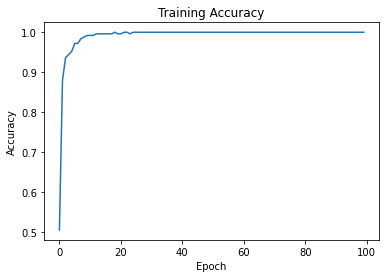

In [44]:
acc = history.history['accuracy']

plt.title('Training Accuracy')
sns.lineplot(data = acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

## Check model performance

In [45]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

report = metrics.classification_report(y_test, predicted_classes, target_names=class_labels)
print(report)

                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       0.95      1.00      0.98        20
Viral Pneumonia       1.00      0.95      0.97        20

       accuracy                           0.98        66
      macro avg       0.98      0.98      0.98        66
   weighted avg       0.99      0.98      0.98        66

